# 编程实现5类最优化算法

In [1]:
import numpy as np
from sympy import *

### 定义目标函数(若要测试不同目标函数，更换f表达式即可)

In [2]:
x1 = symbols("x1")
x2 = symbols("x2")
x = np.array([x1, x2])
f = (x1 ** 3 - x2) ** 2 + 2 * (x2 - x1) ** 4
df = [diff(f, x_) for x_ in x]

### 最速下降法-算法实现
方向d就是负梯度方向；步长$\alpha$我们这里运用Amijo-Goldstein条件的非精确线性搜索求近似值。

In [3]:
def calculate_alpha(f, df, x, xk, d): #Amijo-Goldstein
    (l,r,alpha,rho,t)=(0,1,0.75,0.3,2)
    find_yet = False
    while find_yet != True:
        if f.subs(zip(x, xk + alpha * d)) > f.subs(zip(x, xk)) + rho * alpha * np.dot([df_k.subs(zip(x,xk)) for df_k in df], d):
            r = alpha
            alpha = (l + r) / 2
        elif f.subs(zip(x, xk + alpha * d)) < f.subs(zip(x, xk)) + (1 - rho) * alpha * np.dot([df_k.subs(zip(x,xk)) for df_k in df], d):
            l = alpha
            if t>1:
                alpha = alpha * t
            else:
                alpha = alpha = (l + r) / 2
        else:
            find_yet = True
    return alpha
    
def steepest_descent_method(f, df, x, x0):
    xk = x0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-6:
        d = -g
        alpha = calculate_alpha(f, df, x, xk, d)
        xk = xk + alpha * d
        g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    print_result(xk, f.subs(zip(x, xk)))

### 牛顿法-算法实现
方向d是用Hessian阵的逆矫正的负梯度方向；牛顿法步长$\alpha=1$

In [4]:
def calculate_Hessian(df, x):
    H = [[diff(df_j, xi) for xi in x] for df_j in df]
    return H
    
def Newton_method(f, df, x, x0):
    H = calculate_Hessian(df, x)
    xk = x0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-6:
        inv_H = np.linalg.inv(np.array([[hij.subs(zip(x, xk)) for hij in hi] for hi in H],dtype='float'))
        d = -np.dot(inv_H, g)
        alpha = 1
        xk = xk + alpha * d
        g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    print_result(xk, f.subs(zip(x, xk)))

### 阻尼牛顿法-算法实现
方向d是用Hessian阵的逆矫正的负梯度方向；牛顿法步长$\alpha$我们这里运用Amijo-Goldstein条件的非精确线性搜索求近似值。

In [5]:
def Damped_Newton_method(f, df, x, x0):
    H = calculate_Hessian(df, x)
    xk = x0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-6:
        inv_H = np.linalg.inv(np.array([[hij.subs(zip(x, xk)) for hij in hi] for hi in H],dtype='float'))
        d = -np.dot(inv_H, g)
        alpha = calculate_alpha(f, df, x, xk, d)
        xk = xk + alpha * d
        g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    print_result(xk, f.subs(zip(x, xk)))

### 共轭梯度法-算法实现
方向d是在负梯度方向基础上矫正的与之前方向的共轭方向（FR算法）；牛顿法步长$\alpha$我们这里运用Amijo-Goldstein条件的非精确线性搜索求近似值。

In [6]:
def calculate_beta(g, pre_g):  #FR
    return np.dot(g, g) / np.dot(pre_g, pre_g)

def Conjugate_Gradient_method(f, df, x, x0):
    xk = x0
    d = np.zeros_like(x)
    pre_g, g = -np.ones_like(x), np.array([df_k.subs(zip(x,xk)) for df_k in df])
    while sqrt(np.sum([x ** 2 for x in g])) >= 1e-6:
        beta = calculate_beta(g, pre_g)
        d = -g + beta * d
        alpha = calculate_alpha(f, df, x, xk, d)
        xk = xk + alpha * d
        pre_g, g = g.copy(), np.array([df_k.subs(zip(x,xk)) for df_k in df])
    print_result(xk, f.subs(zip(x, xk)))

### 拟牛顿法-算法实现
方向d是用近似的Hessian阵的逆矫正的负梯度方向；牛顿法步长$\alpha$我们这里运用Amijo-Goldstein条件的非精确线性搜索求近似值。

In [7]:
def Quasi_Newton_method(f, df, x, x0):
    H = np.identity(x.shape[0])
    xk = x0
    g = np.array([df_k.subs(zip(x,xk)) for df_k in df])
    while True:
        d = -np.dot(H, g)
        alpha = calculate_alpha(f, df, x, xk, d)
        pre_xk, xk = xk.copy(), xk + alpha * d
        pre_g, g = g.copy(), np.array([df_k.subs(zip(x,xk)) for df_k in df])
        if sqrt(np.sum([x ** 2 for x in g])) < 1e-6:
            break
        else:
            s, y = xk - pre_xk, g - pre_g
            M_ = np.identity(x.shape[0]) - np.outer(s,y) / np.dot(s,y)
            H = np.matmul(np.matmul(M_, H), M_.T) + np.outer(s,s) / np.dot(s,y)
    print_result(xk, f.subs(zip(x, xk)))

### 运算结果(选取不同初始点，输出五个模型的结果)

In [8]:
def print_result(best_point, best_value):
    print("the best point is:",end=" ")
    print(best_point)
    print("and the function value is:%f"%(best_value))

#### 初始点为[2,3]时

In [9]:
x0 = np.array([2,3])
print("最速下降法结果：")
steepest_descent_method(f, df, x, x0)
print("牛顿法结果：")
Newton_method(f, df, x, x0)
print("阻尼牛顿法结果：")
Damped_Newton_method(f, df, x, x0)
print("共轭梯度法结果：")
Conjugate_Gradient_method(f, df, x, x0)
print("拟牛顿法结果：")
Quasi_Newton_method(f, df, x, x0)

最速下降法结果：
the best point is: [1.00288322990867 1.00867436833950]
and the function value is:0.000000
牛顿法结果：
the best point is: [1.00032922605037 1.00098792712833]
and the function value is:0.000000
阻尼牛顿法结果：
the best point is: [1.00043814150574 1.00131489153335]
and the function value is:0.000000
共轭梯度法结果：
the best point is: [1.00156845245841 1.00471281081733]
and the function value is:0.000000
拟牛顿法结果：
the best point is: [1.00035166400898 1.00105526013889]
and the function value is:0.000000


#### 初始点为[-1.5, -2]时

In [10]:
x0 = np.array([-1.5, -2])
print("最速下降法结果：")
steepest_descent_method(f, df, x, x0)
print("牛顿法结果：")
Newton_method(f, df, x, x0)
print("阻尼牛顿法结果：")
Damped_Newton_method(f, df, x, x0)
print("共轭梯度法结果：")
Conjugate_Gradient_method(f, df, x, x0)
print("拟牛顿法结果：")
Quasi_Newton_method(f, df, x, x0)

最速下降法结果：
the best point is: [-1.00288463214373 -1.00867859844828]
and the function value is:0.000000
牛顿法结果：
the best point is: [-1.00035074848392 -1.00105252804542]
and the function value is:0.000000
阻尼牛顿法结果：
the best point is: [-1.00049368294479 -1.00148164176378]
and the function value is:0.000000
共轭梯度法结果：
the best point is: [-1.00215951858108 -1.00649256743005]
and the function value is:0.000000
拟牛顿法结果：
the best point is: [-1.00036890113676 -1.00110699928799]
and the function value is:0.000000


### 结果分析
五个算法对同一个初始点几乎都得到了相同的结果，最优解主要和不同初始点有关系，当然与不同算法、甚至是非精确线性搜索中不同的参数都是有关系的。

值得一提的是这些算法所花费的时间！最速下降法非常慢，牛顿法、阻尼牛顿法、共轭梯度法和拟牛顿法速度明显比最速下降法快得多。

### 结果验证
#### 其实根据观察目标函数可发现只有当二次项$x_1^3-x_2=0$且$x_2-x_1=0$时才取得最小值，解得$x_1=x_2=0 \, or \, 1 \, or \, -1$
#### 我们可以绘制出该2维函数的3d图像，如下：

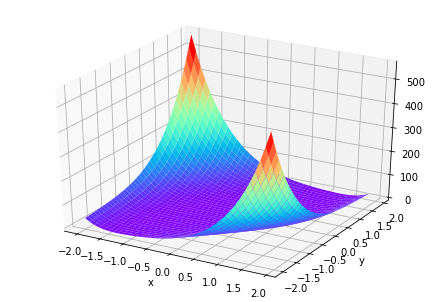

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
 
fig = plt.figure()
ax = Axes3D(fig)
x=np.arange(-2,2,0.1)
y=np.arange(-2,2,0.1)
X, Y = np.meshgrid(x, y)#网格的创建，这个是关键
Z=(X ** 3 - Y) ** 2 + 2 * (Y - X) ** 4
plt.xlabel('x')
plt.ylabel('y')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()